In [129]:
import numpy as np # библиотека c большим количеством математических функций 
import pandas as pd # библиотека для работы с данными в табличной форме
import os # библиотека для для работы с системными и файловыми функциями
import pandas as pd # библиотека для работы с данными в табличной форме
import re
from Levenshtein import ratio # метод нормализации расстояния

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import sent_tokenize 

from gensim.parsing.preprocessing import remove_stopwords, preprocess_string

import tensorflow_text as tf_text
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Тувинский корпус

In [53]:
# Подключаем датасеты(корпус)
shyn_new = '/kaggle/input/tuvan-language-in-articles/shin2023.json'
with open(shyn_new, 'r', encoding='utf-8') as f:
    df_shyn_new = pd.read_json(f)
#df_shyn_new = df_shyn_new[['id', 'text_only']]
df_shyn_new = pd.DataFrame(df_shyn_new.text_only)

gov_new = '/kaggle/input/tuvan-language-in-articles/govtuva_tu_2023.json'
with open(gov_new, 'r', encoding='utf-8') as f:
    df_gov_new = pd.read_json(f)
df_gov_new = pd.DataFrame(df_gov_new.text_only)

shyn = pd.read_csv('/kaggle/input/tuvan-language-in-articles/tuva_text.csv')
gov = pd.read_csv('/kaggle/input/tuvan-language-in-articles/govtuva.csv')
chelesh = pd.read_csv('/kaggle/input/tuvan-language-in-articles/chelesh.csv')

# Переименование столбов датафрейма
df_gov_new.columns = ['text']
df_shyn_new.columns = ['text']
shyn.columns = ['id','text']
gov.columns = ['id','text']
chelesh.columns = ['id','text']

print(f'Корпус статей Правительства(2023): {len(df_gov_new)} статей')
print(f'Корпус статей Правительства старый: {len(gov)} статей')
print(f'Корпус статей Шын старый: {len(shyn)} статей')
print(f'Корпус статей Шын новый(2023): {len(df_shyn_new)} статей')
print(f'Корпус статей Челеш: {len(chelesh)} статей')

# Слияние таблиц
data = pd.concat([shyn,gov, chelesh, df_shyn_new, df_gov_new], ignore_index=True)
del data['id']
data.dropna
df_tu = data
print(f'Всего в корпусе: {len(df_tu)} статей')
print('-' * 20)


Корпус статей Правительства(2023): 5146 статей
Корпус статей Правительства старый: 3539 статей
Корпус статей Шын старый: 4680 статей
Корпус статей Шын новый(2023): 2250 статей
Корпус статей Челеш: 43 статей
Всего в корпусе: 15658 статей
--------------------


# Русский корпус

In [54]:
file_ru = '/kaggle/input/tuvan-language-in-articles/govtuva_ru.json'
with open(file_ru, 'r', encoding='utf-8') as f:
    df_ru = pd.read_json(f)
#df_shyn_new = df_shyn_new[['id', 'text_only']]
df_ru = pd.DataFrame(df_ru.text_only)


# Обработка корпуса

In [55]:
# Удаляем дубликаты статей
def clear_dub_art(dataframe, column_name):
    unic = pd.unique(dataframe[[column_name]].values.ravel())
    df_unic = pd.DataFrame(unic)
    return df_unic
    
df_tu = clear_dub_art(df_tu, 'text')
df_ru = clear_dub_art(df_ru, 'text_only')

df_tu.columns = ['text']
df_ru.columns = ['text']

In [56]:
def clear_full(word):
    """Очистка слова"""
    alf_up = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯҮӨҢ-'
    alf_dw = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяүөң'
    alf = alf_up+alf_dw
    res = [x for x in list(word) if x in list(alf)]
    return ''.join(res)

# Функция для очистки текста от лишних символов
def clean_text(text):
    # приводим текст к нижнему регистру
    # создаем регулярное выражение для удаления лишних символов
    regular = r'[\*+\!+\«+\“+\_+\”+\'+\{+\@+\[+\]+\}+\%+\»+\^+\$+\#+\№\"\+\=+\?+\&\^\.+\;\,+\>+\(\)\/+\:\\+]'
    # регулярное выражение для замены ссылки на "URL"
    regular_url = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)'
    # удаляем лишние символы
    text = re.sub(regular, ' ', text)
    # заменяем ссылки на "URL"
    text = re.sub(regular_url, r' ', text)
    # заменяем числа и цифры на ' NUM '
    text = re.sub(r'(\d+\s\d+)|(\d+)',' ', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # возвращаем очищенные данные
    return text

def min_clear(text):
    text_arr = []
    for x in text.split():
        if list(x)[0] != '-':
            if list(x)[-1] != '-':
                text_arr.append(x.lower())
    return ' '.join(text_arr)

def clear_word_one(text):
    text_arr = []
    for x in text.split():
        if x:
            x = clear_full(x)
            text_arr.append(x)
    return ' '.join(text_arr)

df_tu['pre'] = df_tu['text'].apply(lambda x: clean_text(x))
df_tu['pre'] = df_tu['pre'].apply(lambda x: min_clear(x))
df_tu['pre'] = df_tu['pre'].apply(lambda x: clear_word_one(x))

df_ru['pre'] = df_ru['text'].apply(lambda x: clean_text(x))
df_ru['pre'] = df_ru['pre'].apply(lambda x: min_clear(x))
df_ru['pre'] = df_ru['pre'].apply(lambda x: clear_word_one(x))

In [265]:
df_tu['label'] = 1
df_ru['label'] = 0

,text,pre,label
0,\n27 сентября по всей стране отмечают День вос...,сентября по всей стране отмечают день воспитат...,0
1,"\nhttps://vk.com/karaool: \nЗавершается год, п...",завершается год подводим его итоги министры...,0
2,\nХод строительства мараловодческого хозяйства...,ход строительства мараловодческого хозяйства н...,0
3,\nГлава Тувы Шолбан Кара-оол обнародовал сведе...,глава тувы шолбан кара-оол обнародовал сведени...,0
4,\nТува лидирует среди субъектов Сибирского фед...,тува лидирует среди субъектов сибирского федер...,0
...,...,...,...
10397,"\nВ понедельник на аппаратном совещании, котор...",в понедельник на аппаратном совещании которое ...,0
10398,\nПо итогам минувшего года республика вошла в ...,по итогам минувшего года республика вошла в дв...,0
10399,\nНакануне врио Главы Тувы Владислав Ховалыг п...,накануне врио главы тувы владислав ховалыг пос...,0
10400,\nПравительство Тувы инициирует расширение доп...,правительство тувы инициирует расширение допол...,0


In [266]:
# Объеденяем русский и тувинский корпус в один
corpuse_turu = pd.concat([df_tu[:10000],df_ru[:10000]], ignore_index=True)
df = corpuse_turu.sample(frac=1).reset_index(drop=True)
df

,text,pre,label
0,\nОбсуждение отчета деятельности Правительства...,обсуждение отчета деятельности правительства р...,0
1,Ава адап ханмас үнелиг сөс. Ава чаш кижиниң би...,ава адап ханмас үнелиг сөс ава чаш кижиниң бир...,1
2,\nПремьер Шолбан Кара-оол на протяжении всего ...,премьер шолбан кара-оол на протяжении всего го...,0
3,\n\n11.02.2023\n\r\n\tВ. Көк-оол аттыг Национа...,в көк-оол аттыг национал театрга тываның башкы...,1
4,Бо неделяның эгезинде Тывада 55-ки мото-адыгжы...,бо неделяның эгезинде тывада мото-адыгжы даг б...,1
...,...,...,...
19995,Мөңгүн-Тайгада сиген шөлдерниң 60 хуузу кааңн...,мөңгүн-тайгада сиген шөлдерниң хуузу кааңнаашк...,1
19996,Тыва биле Моолдуң хоорайлар аразынга авиарейст...,тыва биле моолдуң хоорайлар аразынга авиарейст...,1
19997,\nГлава Тувы Шолбан Кара-оол находится с рабоч...,глава тувы шолбан кара-оол находится с рабочей...,0
19998,\n\r\n\tГлава Тувы Владислав Ховалыг на аппар...,глава тувы владислав ховалыг на аппаратном сов...,0


# Создание модели

In [267]:
df

,text,pre,label
0,\nОбсуждение отчета деятельности Правительства...,обсуждение отчета деятельности правительства р...,0
1,Ава адап ханмас үнелиг сөс. Ава чаш кижиниң би...,ава адап ханмас үнелиг сөс ава чаш кижиниң бир...,1
2,\nПремьер Шолбан Кара-оол на протяжении всего ...,премьер шолбан кара-оол на протяжении всего го...,0
3,\n\n11.02.2023\n\r\n\tВ. Көк-оол аттыг Национа...,в көк-оол аттыг национал театрга тываның башкы...,1
4,Бо неделяның эгезинде Тывада 55-ки мото-адыгжы...,бо неделяның эгезинде тывада мото-адыгжы даг б...,1
...,...,...,...
19995,Мөңгүн-Тайгада сиген шөлдерниң 60 хуузу кааңн...,мөңгүн-тайгада сиген шөлдерниң хуузу кааңнаашк...,1
19996,Тыва биле Моолдуң хоорайлар аразынга авиарейст...,тыва биле моолдуң хоорайлар аразынга авиарейст...,1
19997,\nГлава Тувы Шолбан Кара-оол находится с рабоч...,глава тувы шолбан кара-оол находится с рабочей...,0
19998,\n\r\n\tГлава Тувы Владислав Ховалыг на аппар...,глава тувы владислав ховалыг на аппаратном сов...,0


In [268]:
# Разделение данных на тексты и метки
texts = df['text'].astype(str)
#texts = df['pre'].astype(str)
labels = df['label']

In [269]:
# Разделение данных на обучающую и тестовую выборки
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [270]:
num_words_glob = 1000
maxlen_glob = 10

In [271]:
# Токенизация и подготовка данных
tokenizer = Tokenizer(num_words=num_words_glob, oov_token="<OOV>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True
)
tokenizer.fit_on_texts(texts_train)
train_sequences = tokenizer.texts_to_sequences(texts_train)
train_padded = pad_sequences(train_sequences, maxlen=maxlen_glob)

test_sequences = tokenizer.texts_to_sequences(texts_test)
test_padded = pad_sequences(test_sequences, maxlen=maxlen_glob)

In [272]:
# Создание модели
model = Sequential([
    Embedding(num_words_glob, 16, input_length=maxlen_glob),
    GlobalAveragePooling1D(),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [273]:
# Обучение модели
history = model.fit(train_padded, labels_train, epochs=10, validation_data=(test_padded, labels_test))

Epoch 1/10
500/500 [==============================] - 2s 3ms/step - loss: 0.2137 - accuracy: 0.9554 - val_loss: 0.0261 - val_accuracy: 0.9958
Epoch 2/10
500/500 [==============================] - 1s 2ms/step - loss: 0.0175 - accuracy: 0.9970 - val_loss: 0.0166 - val_accuracy: 0.9958
Epoch 3/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0120 - accuracy: 0.9976 - val_loss: 0.0133 - val_accuracy: 0.9960
Epoch 4/10
500/500 [==============================] - 1s 2ms/step - loss: 0.0093 - accuracy: 0.9980 - val_loss: 0.0116 - val_accuracy: 0.9962
Epoch 5/10
500/500 [==============================] - 1s 2ms/step - loss: 0.0075 - accuracy: 0.9984 - val_loss: 0.0104 - val_accuracy: 0.9960
Epoch 6/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.0102 - val_accuracy: 0.9965
Epoch 7/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.0103 - val_accuracy: 0.9962
Epoch 

In [274]:
# Оценка модели на тестовых данных
loss, accuracy = model.evaluate(test_padded, labels_test)
print(f"Тестовая потеря: {loss}, Тестовая точность: {accuracy}")

125/125 [==============================] - 0s 2ms/step - loss: 0.0099 - accuracy: 0.9973
Тестовая потеря: 0.009892194531857967, Тестовая точность: 0.9972500205039978


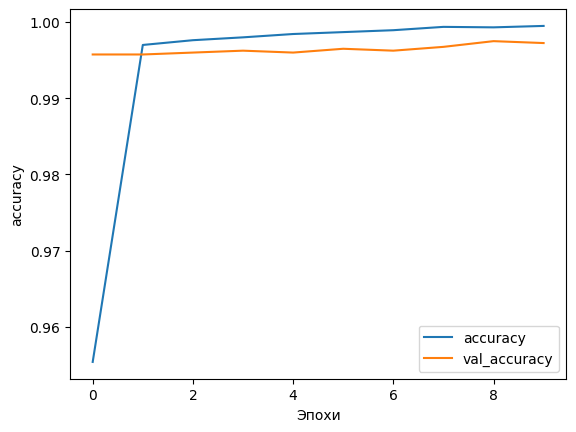

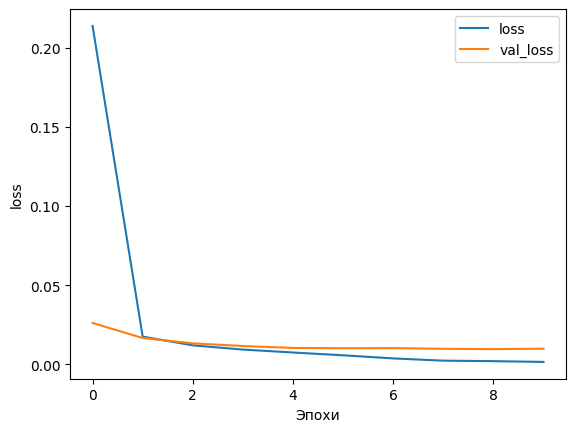

In [275]:
# Визуализация результатов обучения
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Эпохи")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [278]:
# Предсказание (пример)
test_sentence = ["""

 Президент ооң бодалы-биле алырга, регионалдыг-даа, муниципалдыг-даа деңнелде деткиир ужурлуг регионнарда спортчу инфраструктура хөгжүлдезиниң айтырыын көрген. Ооң келир үеде президент программазының угланыышкыны ол апаарын Владимир Путин чугаалаан. Бо чылын Тывада Каа-Хем суурда спортчу-культура төвүнде тудуг ажылдарын федералдыг бюджеттен деткиирин уламчылаар. «Демография» национал төлевилелдиң «Спорт – амыдыралдың нормазы» регионалдыг төлевилел боттандырылгазы-биле ийи чыл иштинде 300 млн ажыг рубльди тускайлап үндүрген.  


Президент также затронул вопрос развития спортивной инфраструктуры в регионах. По его мнению, нужно поддерживать спорт как на региональном, так и на муниципальном уровне. Это направление будет в будущей президентской программе, сообщил Владимир Путин. В Туве в этом году при поддержке федерального бюджета продолжаются строительные работы на спортивно-культурном центре (СКЦ) в пгт Каа-Хем. Более 300 млн. рублей в течение двух лет будет выделено в рамках реализации регионального проекта «Спорт – норма жизни» национального проекта «Демография». 


"""]
test_seq = tokenizer.texts_to_sequences(test_sentence)
test_padded = pad_sequences(test_seq, maxlen=maxlen_glob)
prediction = model.predict(test_padded)
print("Предсказание:", prediction[0][0])

1/1 [==============================] - 0s 26ms/step
Предсказание: 0.9999999


In [279]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 10, 16)            16000     
                                                                 
 global_average_pooling1d_2  (None, 16)                0         
 2 (GlobalAveragePooling1D)                                      
                                                                 
 dense_41 (Dense)            (None, 24)                408       
                                                                 
 dense_42 (Dense)            (None, 1)                 25        
                                                                 
Total params: 16433 (64.19 KB)
Trainable params: 16433 (64.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [280]:
model.save('turu.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [282]:
# Расчет Приблизительного Размера в Памяти
total_parameters = sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
memory_size_in_bytes = total_parameters * 4  # float32 занимает 4 байта
memory_size_in_megabytes = memory_size_in_bytes / (1024 ** 2)
print(memory_size_in_megabytes)

0.06268692016601562


# Загрузка модели

In [284]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/turu.h5')

In [287]:
# Предположим, у вас есть текст для предсказания
text_to_predict = ["""

 Президент ооң бодалы-биле алырга, регионалдыг-даа, муниципалдыг-даа деңнелде деткиир ужурлуг регионнарда спортчу инфраструктура хөгжүлдезиниң айтырыын көрген. Ооң келир үеде президент программазының угланыышкыны ол апаарын Владимир Путин чугаалаан. Бо чылын Тывада Каа-Хем суурда спортчу-культура төвүнде тудуг ажылдарын федералдыг бюджеттен деткиирин уламчылаар. «Демография» национал төлевилелдиң «Спорт – амыдыралдың нормазы» регионалдыг төлевилел боттандырылгазы-биле ийи чыл иштинде 300 млн ажыг рубльди тускайлап үндүрген.  


Президент также затронул вопрос развития спортивной инфраструктуры в регионах. По его мнению, нужно поддерживать спорт как на региональном, так и на муниципальном уровне. Это направление будет в будущей президентской программе, сообщил Владимир Путин. В Туве в этом году при поддержке федерального бюджета продолжаются строительные работы на спортивно-культурном центре (СКЦ) в пгт Каа-Хем. Более 300 млн. рублей в течение двух лет будет выделено в рамках реализации регионального проекта «Спорт – норма жизни» национального проекта «Демография». 


"""]

# Подготовка текста (используйте тот же токенизатор, что и при обучении)
# Здесь предполагается, что у вас есть доступ к токенизатору, использованному при обучении
sequences = tokenizer.texts_to_sequences(text_to_predict)
padded = pad_sequences(sequences, maxlen=10)  # предполагается, что maxlen был 20 при обучении

# Выполнение предсказания
prediction = model.predict(padded)
print(prediction)

1/1 [==============================] - 0s 32ms/step
[[0.9999999]]
